In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import openai
import tiktoken
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
openai.api_key = "sk-proj-q_wz7jftR_3UkuI7SwQEnIpV8Q8YejgOWLlt0219-hEnV7ye6vU97Q0zPSs4Jn3v08xNhxys7CT3BlbkFJuykLa0gKb4e3OxDNd6HYIht7BtUw1bfMG9_0w6ccIkcJi58a7EefkFkPHIjpbUiaLDf3QW0kM"

# Load the data from drive
file_path = '/content/drive/MyDrive/Reasoning/reasoning_input.xlsx'
data_set = pd.read_excel(file_path)

# Data cleaning
data_set = data_set.dropna()
allowed_activities = ['stand', 'sit', 'bike', 'walk']
data_set = data_set[data_set['true_label'].isin(allowed_activities)]

# Show the balance of the selected activities
activity_counts = data_set['true_label'].value_counts()
print("Activity counts:\n", activity_counts)
balance_ratio = activity_counts.min() / activity_counts.max()
print("Balance ratio:", balance_ratio)

Activity counts:
 true_label
bike     100
sit      100
stand    100
walk     100
Name: count, dtype: int64
Balance ratio: 1.0


In [ ]:
# Extract windows and true labels
windows = data_set['window_values'].tolist()
true_labels = data_set['true_label'].tolist()

# Count the number of windows
num_windows = len(windows)
print(f"Number of windows: {num_windows}")

# Convert string back to lists
import ast
if isinstance(windows[0], str):
    windows = [ast.literal_eval(window) for window in windows]
    print("Converted windows from string to list structure")

Number of windows: 400
Converted windows from string to list structure


In [ ]:

def make_prompt(window_values):
    categories = ", ".join(['stand','sit','bike','walk'])
    acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z = window_values

    prompt = f"""
### Instruction:
Instruction: You are an expert of IMU-based human activity analysis
Question: The IMU data is collected from a mobile phone attached to the user's body with a sampling rate of 50 Hz and overlapping 0%. The IMU data is given in the IMU coordinate frame. The three-axis accelerations recording is given below.
x-axis: {acc_x}
y-axis: {acc_y}
z-axis: {acc_z}
The three-axis angular velocities recording is given below.
x-axis: {gyro_x}
y-axis: {gyro_y}
z-axis: {gyro_z}
The person's action belongs to one of the following categories: [{categories}].
Task: Based on the given IMU data, choose only one action form: [{categories}] that best represents the person's activity.
Extract Features and make analyze step by step.

### Response:
"""
    return prompt

In [ ]:
#Token Counting Function
def count_tokens(text, model="gpt-5"):
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(text))
    return num_tokens

In [ ]:
# Label Extraction Function
def extract_label_from_reasoning(reasoning_text):
    """
    Extract the predicted label from reasoning text using simple label extraction.
    """
    reasoning_lower = reasoning_text.lower()


    # Look for activity names near the end (last 50 characters)
    last_part = reasoning_lower[-50:]
    activities_found = []

    for activity in allowed_activities:
        if activity in last_part:
            count = last_part.count(activity.lower())
            activities_found.append((activity, count))

    if activities_found:
        activities_found.sort(key=lambda x: x[1], reverse=True)
        return activities_found[0][0]

    # Count all activity mentions in entire text
    all_mentions = []
    for activity in allowed_activities:
        count = reasoning_lower.count(activity.lower())
        if count > 0:
            all_mentions.append((activity, count))

    if all_mentions:
        if len(all_mentions) == 1:
            return all_mentions[0][0]
        else:
            all_mentions.sort(key=lambda x: x[1], reverse=True)
            if len(all_mentions) > 1 and all_mentions[0][1] >= 2 * all_mentions[1][1]:
                return all_mentions[0][0]
            else:
                return "uncertain_multiple"

    return "unknown"

In [ ]:
# Classification Function
def classify_window(window_values):
    prompt = make_prompt(window_values)

    # Count the number of tokens before the submit
    num_tokens_input = count_tokens(prompt)

    try:
        response = openai.chat.completions.create(
            model="gpt-5",
            messages=[{"role": "user", "content": prompt}],
        )
        reasoning_output = response.choices[0].message.content.strip()
        num_tokens_output = count_tokens(reasoning_output)

        # Use label extraction
        predicted_label = extract_label_from_reasoning(reasoning_output)

        return predicted_label, reasoning_output, num_tokens_input, num_tokens_output

    except Exception as e:
        print(f"API Error: {e}")
        return "unknown", f"Error: {e}", num_tokens_input, 0

In [ ]:
#Setup File Paths and Resume Logic
# File paths
predictions_csv = "/content/drive/MyDrive/Reasoning/predictions_with_reasoning.csv"

if os.path.exists(predictions_csv):
    readTheFile = pd.read_csv(predictions_csv)
    start_index = len(readTheFile)
    pred_labels = readTheFile["prediction"].tolist()
    reasoning_outputs = readTheFile["reasoning"].tolist()
    input_tokens = readTheFile["input_tokens"].tolist()
    output_tokens = readTheFile["output_tokens"].tolist()
    print(f"Resuming from index {start_index}")
else:
    start_index = 0
    pred_labels = []
    reasoning_outputs = []
    input_tokens = []
    output_tokens = []
    print("Starting predictions with reasoning:")

Starting predictions with reasoning:


In [ ]:
# Batch Processing Loop
batch_size = 10

for i in range(start_index, len(windows), batch_size):
    batch_windows = windows[i:i+batch_size]

    # label, reasoning, and tokens for each window
    batch_preds = []
    batch_reasoning = []
    batch_input_tokens = []
    batch_output_tokens = []

    for j, w in enumerate(batch_windows):
        print(f"Processing window {i+j+1}/{len(windows)}")
        label, reasoning, tokens_in, tokens_out = classify_window(w)
        batch_preds.append(label)
        batch_reasoning.append(reasoning)
        batch_input_tokens.append(tokens_in)
        batch_output_tokens.append(tokens_out)

    pred_labels.extend(batch_preds)
    reasoning_outputs.extend(batch_reasoning)
    input_tokens.extend(batch_input_tokens)
    output_tokens.extend(batch_output_tokens)

    # Save batch results
    batch_df = pd.DataFrame({
        "window_index": range(i, i+len(batch_windows)),
        "prediction": batch_preds,
        "reasoning": batch_reasoning,
        "input_tokens": batch_input_tokens,
        "output_tokens": batch_output_tokens
    })

    header = not os.path.exists(predictions_csv)
    batch_df.to_csv(predictions_csv, mode="a", header=header, index=False)

    print(f"Processed batch {i} to {i+len(batch_windows)}")
    print(f"Input tokens: {batch_input_tokens}")
    print(f"Output tokens: {batch_output_tokens}")

Processing window 1/400
Processing window 2/400
Processing window 3/400
Processing window 4/400
Processing window 5/400
Processing window 6/400
Processing window 7/400
Processing window 8/400
Processing window 9/400
Processing window 10/400
Processed batch 0 to 10
Input tokens: [5614, 5574, 5572, 5543, 5589, 5508, 5578, 5578, 5607, 5524]
Output tokens: [507, 558, 449, 469, 459, 515, 442, 561, 468, 355]
Processing window 11/400
Processing window 12/400
Processing window 13/400
Processing window 14/400
Processing window 15/400
Processing window 16/400
Processing window 17/400
Processing window 18/400
Processing window 19/400
Processing window 20/400
Processed batch 10 to 20
Input tokens: [5568, 5648, 5752, 5724, 5689, 5732, 5676, 5718, 5737, 5688]
Output tokens: [590, 334, 590, 525, 417, 463, 489, 327, 472, 462]
Processing window 21/400
Processing window 22/400
Processing window 23/400
Processing window 24/400
Processing window 25/400
Processing window 26/400
Processing window 27/400
Pro

In [ ]:
# Evaluation and Results
# Evaluation
results = pd.read_csv(predictions_csv)

# Take the true labels with the predictions of the model
pred_labels = results["prediction"].tolist()


eval_length = min(len(pred_labels), len(true_labels))
pred_labels_eval = pred_labels[:eval_length]
true_labels_eval = true_labels[:eval_length]

accuracy = accuracy_score(true_labels_eval, pred_labels_eval)
precision_weighted = precision_score(true_labels_eval, pred_labels_eval, labels=allowed_activities, average='weighted', zero_division=0)
recall_weighted = recall_score(true_labels_eval, pred_labels_eval, labels=allowed_activities, average='weighted', zero_division=0)
f1_weighted = f1_score(true_labels_eval, pred_labels_eval, labels=allowed_activities, average='weighted', zero_division=0)
cm = confusion_matrix(true_labels_eval, pred_labels_eval, labels=allowed_activities)

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1-score: {f1_weighted:.4f}")
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=allowed_activities, columns=allowed_activities))

# Calculate token statistics
total_input_tokens = sum(input_tokens[:eval_length])
total_output_tokens = sum(output_tokens[:eval_length])
avg_input_tokens = total_input_tokens / eval_length
avg_output_tokens = total_output_tokens / eval_length

print(f"\nToken Statistics:")
print(f"Total Input Tokens: {total_input_tokens}")
print(f"Total Output Tokens: {total_output_tokens}")
print(f"Average Input Tokens per window: {avg_input_tokens:.2f}")
print(f"Average Output Tokens per window: {avg_output_tokens:.2f}")

Accuracy: 0.4225
Weighted Precision: 0.3686
Weighted Recall: 0.4225
Weighted F1-score: 0.3117
Confusion Matrix:
       stand  sit  bike  walk
stand     66    4     4    26
sit       77    3     6    14
bike       0    1     4    95
walk       0    0     4    96

Token Statistics:
Total Input Tokens: 2263289
Total Output Tokens: 192153
Average Input Tokens per window: 5658.22
Average Output Tokens per window: 480.38


In [ ]:
# Save Final Results
# Save the final prediction with the true label and reasoning
final_output_csv = "/content/drive/MyDrive/Reasoning/final_predictions_with_reasoning.csv"
final_df = pd.DataFrame({
    "true_label": true_labels_eval,
    "pred_label": pred_labels_eval,
    "reasoning": reasoning_outputs[:eval_length],
    "input_tokens": input_tokens[:eval_length],
    "output_tokens": output_tokens[:eval_length]
})
final_df.to_csv(final_output_csv, index=False)
print(f"\nFinal results saved to: {final_output_csv}")


Final results saved to: /content/drive/MyDrive/Reasoning/final_predictions_with_reasoning.csv


In [ ]:
import pandas as pd

# Load file
predictions_csv = "/content/drive/MyDrive/Reasoning/final_predictions_with_reasoning.csv"
results = pd.read_csv(predictions_csv)

# Create combined token column
results["total_tokens"] = results["input_tokens"] + results["output_tokens"]

# Compute stats
average_total_tokens = results["total_tokens"].mean()
sum_total_tokens = results["total_tokens"].sum()

print("Average total tokens (input + output):", average_total_tokens)
print("Total tokens used (input + output):", sum_total_tokens)


Average total tokens (input + output): 6138.605
Total tokens used (input + output): 2455442


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load file
predictions_csv = "/content/drive/MyDrive/Reasoning/final_predictions_with_reasoning.csv"
results = pd.read_csv(predictions_csv)

# Token statistics
average_input_tokens = results["input_tokens"].mean()
total_input_tokens = results["input_tokens"].sum()

average_output_tokens = results["output_tokens"].mean()
total_output_tokens = results["output_tokens"].sum()

print("Average input tokens per window:", average_input_tokens)
print("Total input tokens:", total_input_tokens)
print()
print("Average output tokens per window:", average_output_tokens)
print("Total output tokens:", total_output_tokens)

Average input tokens per window: 5658.2225
Total input tokens: 2263289

Average output tokens per window: 480.3825
Total output tokens: 192153


--- Evaluation Results from Excel Data ---
File loaded has 400 rows (or windows) of data.
Metrics calculated for 400 samples.

--- Count of True Labels per Activity ---
true_label
stand    100
sit      100
bike     100
walk     100
Name: count, dtype: int64

-------------------------------------------
Accuracy: 0.4225
Weighted Precision: 0.3686
Weighted Recall: 0.4225
Weighted F1-score: 0.3117


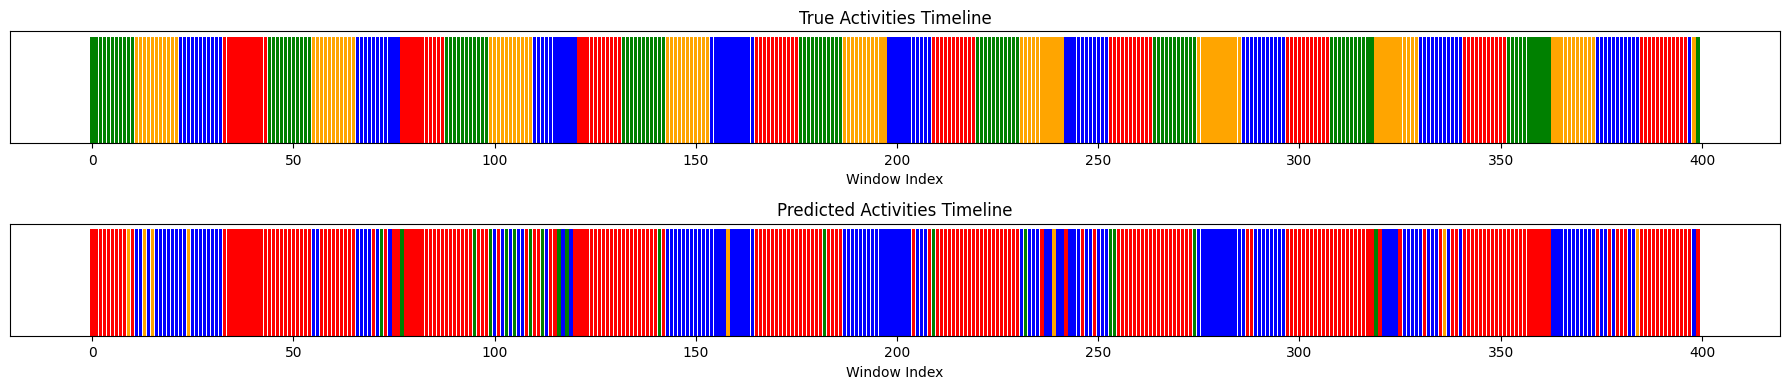

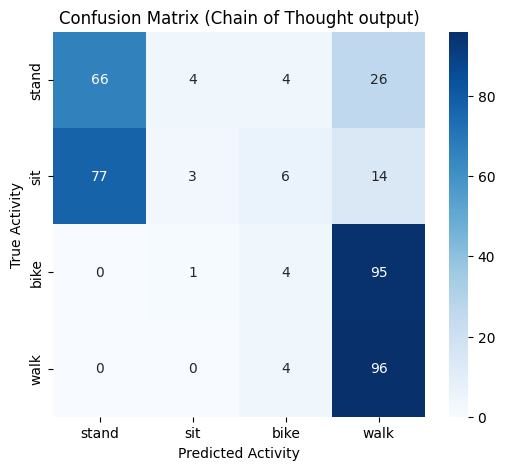

In [ ]:
# Evaluation from Saved Results
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


predictions_xlsx = "/content/drive/MyDrive/Reasoning/final_predictions_with_reasoning.csv"
results = pd.read_csv(predictions_xlsx)

allowed_activities = ['stand', 'sit', 'bike', 'walk']

true_labels = results["true_label"].tolist()
pred_labels = results["pred_label"].tolist()


true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

accuracy = accuracy_score(true_labels, pred_labels)


precision_weighted = precision_score(true_labels, pred_labels, labels=allowed_activities, average='weighted', zero_division=0)
recall_weighted = recall_score(true_labels, pred_labels, labels=allowed_activities, average='weighted', zero_division=0)
f1_weighted = f1_score(true_labels, pred_labels, labels=allowed_activities, average='weighted', zero_division=0)
cm = confusion_matrix(true_labels, pred_labels, labels=allowed_activities)

# Get the number of rows (samples/windows)
num_rows = len(results)

# Count the frequency of each activity in the 'true_labels'
activity_counts = results["true_label"].value_counts().reindex(allowed_activities, fill_value=0)

print(f"--- Evaluation Results from Excel Data ---")
print(f"File loaded has {num_rows} rows (or windows) of data.")
print(f"Metrics calculated for {len(true_labels)} samples.")
print("\n--- Count of True Labels per Activity ---")
print(activity_counts)
print("\n-------------------------------------------")
print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1-score: {f1_weighted:.4f}")

activities = ['stand', 'sit', 'bike', 'walk']
colors = {
    'stand': 'blue',
    'sit': 'orange',
    'bike': 'green',
    'walk': 'red',
    None: 'gray'
}

clean_pred_labels = [p if p in activities else None for p in pred_labels]

plt.figure(figsize=(18, 4))

plt.subplot(2, 1, 1)
for i, act in enumerate(true_labels):
    plt.bar(i, 1, color=colors[act])
plt.title("True Activities Timeline")
plt.yticks([])
plt.xlabel("Window Index")

plt.subplot(2, 1, 2)
for i, act in enumerate(clean_pred_labels):
    plt.bar(i, 1, color=colors[act])
plt.title("Predicted Activities Timeline")
plt.yticks([])
plt.xlabel("Window Index")

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=allowed_activities,
            yticklabels=allowed_activities)
plt.xlabel("Predicted Activity")
plt.ylabel("True Activity")
plt.title("Confusion Matrix (Chain of Thought output)")
plt.show()

--- Filtering Summary ---
Total windows in original file: 400
Windows kept for evaluation (walk + stand): 200

--- Count of True Labels (Filtered) ---
walk     100
stand    100
Name: count, dtype: int64

--- Metrics (walk + stand only) ---
Accuracy: 0.8100
Weighted Precision: 0.8934
Weighted Recall: 0.8100
Weighted F1-score: 0.8300


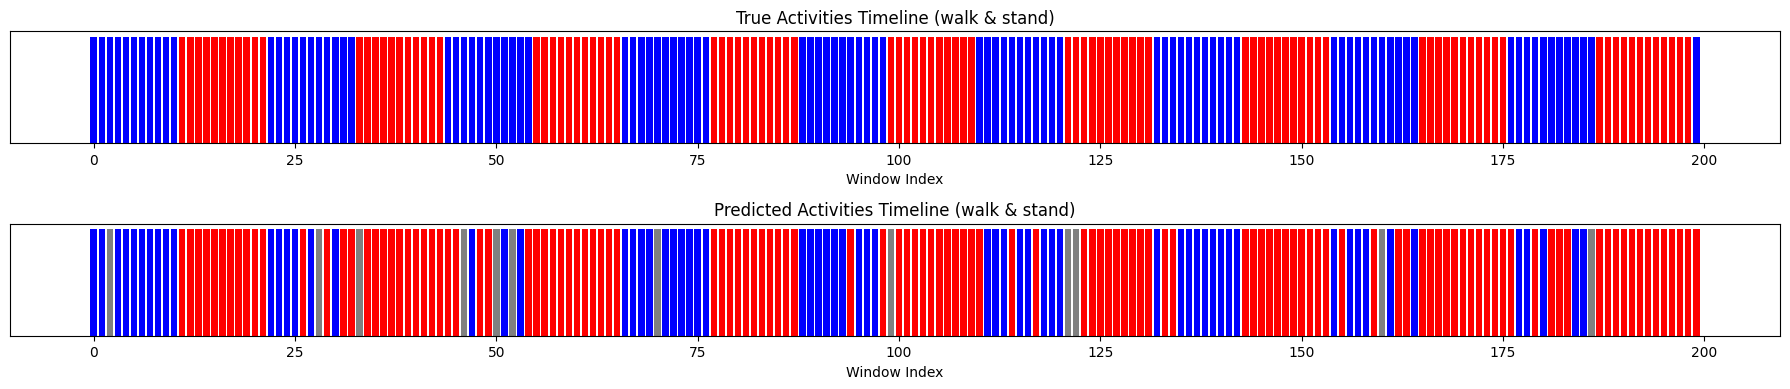

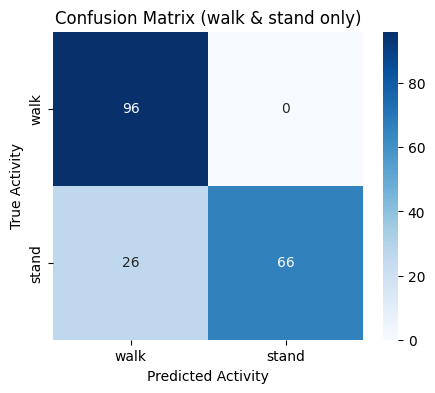

In [ ]:
# Evaluation from Saved Results
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load result file
predictions_xlsx = "/content/drive/MyDrive/Reasoning/final_predictions_with_reasoning.csv"
results = pd.read_csv(predictions_xlsx)

# Activities to evaluate
target_activities = ['walk', 'stand']

# Extract labels
true_labels = np.array(results["true_label"].tolist())
pred_labels = np.array(results["pred_label"].tolist())

# Filter only walk & stand
mask = np.isin(true_labels, target_activities)
true_labels_filtered = true_labels[mask]
pred_labels_filtered = pred_labels[mask]

print(f"--- Filtering Summary ---")
print(f"Total windows in original file: {len(results)}")
print(f"Windows kept for evaluation (walk + stand): {np.sum(mask)}")

# Evaluation metrics
accuracy = accuracy_score(true_labels_filtered, pred_labels_filtered)
precision_weighted = precision_score(true_labels_filtered, pred_labels_filtered, labels=target_activities, average='weighted', zero_division=0)
recall_weighted = recall_score(true_labels_filtered, pred_labels_filtered, labels=target_activities, average='weighted', zero_division=0)
f1_weighted = f1_score(true_labels_filtered, pred_labels_filtered, labels=target_activities, average='weighted', zero_division=0)
cm = confusion_matrix(true_labels_filtered, pred_labels_filtered, labels=target_activities)

# Count true labels
activity_counts = pd.Series(true_labels_filtered).value_counts().reindex(target_activities, fill_value=0)

print("\n--- Count of True Labels (Filtered) ---")
print(activity_counts)

print("\n--- Metrics (walk + stand only) ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1-score: {f1_weighted:.4f}")

# Color mapping for visualization
colors = {
    'stand': 'blue',
    'walk': 'red',
    None: 'gray'
}

clean_pred_labels = [p if p in target_activities else None for p in pred_labels_filtered]

# Timeline plots
plt.figure(figsize=(18, 4))

# True timeline
plt.subplot(2, 1, 1)
for i, act in enumerate(true_labels_filtered):
    plt.bar(i, 1, color=colors[act])
plt.title("True Activities Timeline (walk & stand)")
plt.yticks([])
plt.xlabel("Window Index")

# Predicted timeline
plt.subplot(2, 1, 2)
for i, act in enumerate(clean_pred_labels):
    plt.bar(i, 1, color=colors[act])
plt.title("Predicted Activities Timeline (walk & stand)")
plt.yticks([])
plt.xlabel("Window Index")

plt.tight_layout()
plt.show()

# Heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_activities,
            yticklabels=target_activities)
plt.xlabel("Predicted Activity")
plt.ylabel("True Activity")
plt.title("Confusion Matrix (walk & stand only)")
plt.show()


